In [1]:
import pickle

import numpy
import pandas
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn


with open("resources/se_test_stats.pkl", "rb") as istream:
    test_stats = pickle.load(istream)


print(f"Dictionary keys: {list(test_stats[0].keys())}")


Dictionary keys: ['name', 'frames', 'accuracy', 'conf_matrix', 'training_log']


# Analyzing Accuracies
## First we get them...

In [2]:
def collect_accuracies(test_stats):
    model_accuracies = dict()
    for stat in test_stats:
        if stat["name"] not in model_accuracies:
            model_accuracies[stat["name"]] = list()
        model_accuracies[stat["name"]].append((stat["frames"], stat["accuracy"]))
    
    for key, val in model_accuracies.items():
        model_accuracies[key] = sorted(val, key=lambda x: x[0])
        
    return model_accuracies


accuracies = collect_accuracies(test_stats)

## Then we plot them

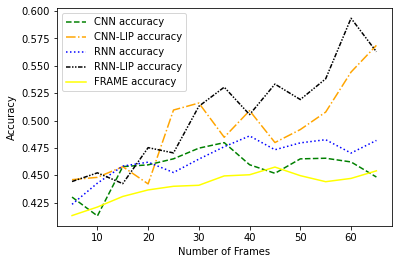

In [3]:
def get_accuracy_series(accuracy_list):
    return ([val[0] for val in accuracy_list], [val[1] for val in accuracy_list])

frames, cnn_acc = get_accuracy_series(accuracies["cnn"])
plt.plot(frames, cnn_acc, color="green", label="CNN accuracy", linestyle="--")
frames, cnn_lip_acc = get_accuracy_series(accuracies["cnn_lip"])
plt.plot(frames, cnn_lip_acc, color="orange", label="CNN-LIP accuracy", linestyle="-.")
frames, rnn_acc = get_accuracy_series(accuracies["rnn"])
plt.plot(frames, rnn_acc, color="blue", label="RNN accuracy", linestyle=":")
frames, rnn_lip_acc = get_accuracy_series(accuracies["rnn_lip"])
plt.plot(frames, rnn_lip_acc, color="black", label="RNN-LIP accuracy", linestyle=(0, (3, 1, 1, 1, 1, 1)))
x = frames, frame_acc = get_accuracy_series(accuracies["frame"])
plt.plot(frames, frame_acc, color="yellow", label="FRAME accuracy", linestyle="-")

plt.xlabel("Number of Frames")
plt.ylabel("Accuracy")

plt.legend()

plt.savefig("resources/accuracies.pdf")

In [4]:
df = pandas.DataFrame()
df["frames"] = frames
df["CNN"] = cnn_acc
df["CNN lip"] = cnn_lip_acc
df["RNN"] = rnn_acc
df["RNN lip"] = rnn_lip_acc
df["FRAME"] = frame_acc
df["CNN diff"] = df["CNN lip"] - df["CNN"]
df["RNN diff"] = df["RNN lip"] - df["RNN"]

latex = df.to_latex()

with open("resources/accuracies_table.tex", "w") as ostream:
    ostream.write(latex)

## Let's plot the difference between the lip models and the non-lip ones

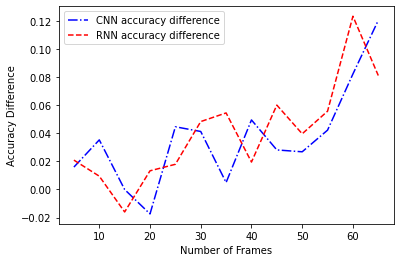

In [6]:
cnn_acc_diff = numpy.array(cnn_lip_acc) - numpy.array(cnn_acc)
rnn_acc_diff = numpy.array(rnn_lip_acc) - numpy.array(rnn_acc)

plt.plot(frames, cnn_acc_diff, color="blue", label="CNN accuracy difference", linestyle="-.")
plt.plot(frames, rnn_acc_diff, color="red", label="RNN accuracy difference", linestyle="--")

plt.xlabel("Number of Frames")
plt.ylabel("Accuracy Difference")

plt.legend()

plt.savefig("resources/accuracies_diff.pdf")

## Plot the regression line and get the intercept value

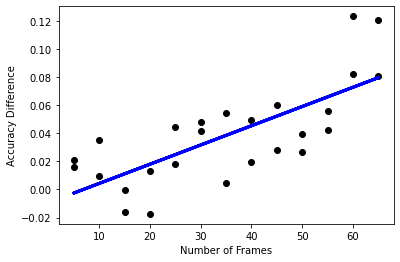

In [8]:
cum_y = numpy.concatenate([cnn_acc_diff, rnn_acc_diff])
cum_y = cum_y.reshape(-1, 1)
cum_x = numpy.concatenate([frames, frames])
cum_x = cum_x.reshape(-1, 1)

reg = LinearRegression().fit(cum_x, cum_y)
y_pred = reg.predict(cum_x)

# Plot outputs
plt.scatter(cum_x, cum_y,  color='black')
plt.plot(cum_x, y_pred, color='blue', linewidth=3)

plt.xlabel("Number of Frames")
plt.ylabel("Accuracy Difference")

plt.savefig("resources/accuracies_regression.pdf")

## Plot also the original diffs with the regression line

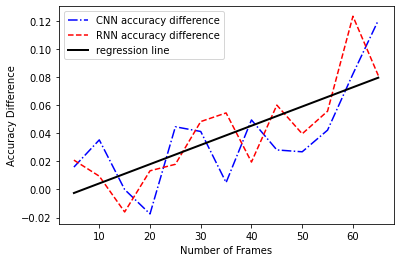

In [9]:
plt.plot(frames, cnn_acc_diff, color="blue", label="CNN accuracy difference", linestyle="-.")
plt.plot(frames, rnn_acc_diff, color="red", label="RNN accuracy difference", linestyle="--")

plt.xlabel("Number of Frames")
plt.ylabel("Accuracy Difference")

y1, y2 = reg.predict([[5], [65]])

plt.plot([5, 65], [y1, y2], color="k", linestyle="-", linewidth=2, label="regression line")

plt.legend()

plt.savefig("resources/accuracies_diff_2.pdf")

## See the fit quality and significance of the parameters

In [8]:
X2 = sm.add_constant(cum_x)
est = sm.OLS(cum_y, X2)
est2 = est.fit()

regression_summary = str(est2.summary())
print(regression_summary)

with open("resources/regression_summary.txt", "w") as ostream:
    ostream.write(regression_summary)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     29.36
Date:                Mon, 25 May 2020   Prob (F-statistic):           1.45e-05
Time:                        18:16:01   Log-Likelihood:                 61.025
No. Observations:                  26   AIC:                            -118.0
Df Residuals:                      24   BIC:                            -115.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0094      0.010     -0.936      0.3

# Comparing Training Logs

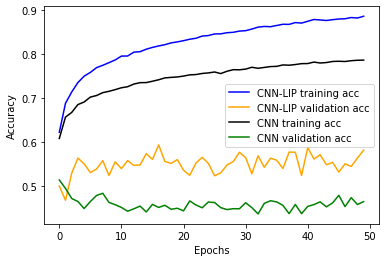

In [11]:
def get_best_performing_model_idx(test_stats, name=None):
    highest_acc, highest_idx = -1, -1
    for idx, ts in enumerate(test_stats):
        if name is not None and name != ts["name"]:
            continue
        if ts["accuracy"] > highest_acc:
            highest_acc = ts["accuracy"]
            highest_idx = idx
    
    # TODO: check for not found
    return highest_idx


def get_model(test_stats, frame, name):
    for ts in test_stats:
        if ts["name"] == name and ts["frames"] == frame:
            return ts
        

best_cnn_model_idx = get_best_performing_model_idx(test_stats, "cnn_lip")
best_cnn_lip = test_stats[best_cnn_model_idx]
cnn_no_lip = get_model(test_stats, best_cnn_lip["frames"], "cnn")

best_rnn_model_idx = get_best_performing_model_idx(test_stats, "rnn_lip")
best_rnn_lip = test_stats[best_rnn_model_idx]
rnn_no_lip = get_model(test_stats, best_rnn_lip["frames"], "rnn")

# for later...
best_frame_model_idx = get_best_performing_model_idx(test_stats, "frame")
best_frame_model = test_stats[best_frame_model_idx]


training_log_cnn_lip = best_cnn_lip["training_log"]
plt.plot(training_log_cnn_lip.epoch, training_log_cnn_lip.accuracy, color="blue", label="CNN-LIP training acc")
plt.plot(training_log_cnn_lip.epoch, training_log_cnn_lip.val_accuracy, color="orange", label="CNN-LIP validation acc")


training_log_cnn = cnn_no_lip["training_log"]
plt.plot(training_log_cnn.epoch, training_log_cnn.accuracy, color="black", label="CNN training acc")
plt.plot(training_log_cnn.epoch, training_log_cnn.val_accuracy, color="green", label="CNN validation acc")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.legend()

plt.savefig("resources/training_log_acc_CNN.pdf")

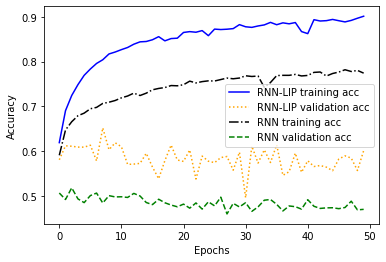

In [14]:
training_log_rnn_lip = best_rnn_lip["training_log"]
plt.plot(training_log_rnn_lip.epoch, training_log_rnn_lip.accuracy, color="blue", label="RNN-LIP training acc", linestyle="-")
plt.plot(training_log_rnn_lip.epoch, training_log_rnn_lip.val_accuracy, color="orange", label="RNN-LIP validation acc", linestyle=":")


training_log_rnn = rnn_no_lip["training_log"]
plt.plot(training_log_rnn.epoch, training_log_rnn.accuracy, color="black", label="RNN training acc", linestyle="-.")
plt.plot(training_log_rnn.epoch, training_log_rnn.val_accuracy, color="green", label="RNN validation acc", linestyle="--")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.legend()

plt.savefig("resources/training_log_acc_RNN.pdf")

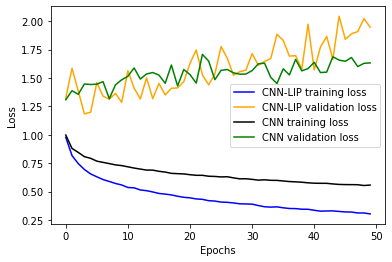

In [11]:
training_log_cnn_lip = best_cnn_lip["training_log"]
plt.plot(training_log_cnn_lip.epoch, training_log_cnn_lip.loss, color="blue", label="CNN-LIP training loss")
plt.plot(training_log_cnn_lip.epoch, training_log_cnn_lip.val_loss, color="orange", label="CNN-LIP validation loss")


training_log_cnn = cnn_no_lip["training_log"]
plt.plot(training_log_cnn.epoch, training_log_cnn.loss, color="black", label="CNN training loss")
plt.plot(training_log_cnn.epoch, training_log_cnn.val_loss, color="green", label="CNN validation loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend()

plt.savefig("resources/training_log_loss_CNN.pdf")

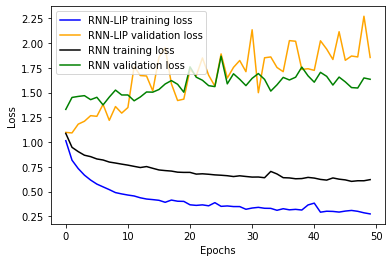

In [12]:
training_log_rnn_lip = best_rnn_lip["training_log"]
plt.plot(training_log_rnn_lip.epoch, training_log_rnn_lip.loss, color="blue", label="RNN-LIP training loss")
plt.plot(training_log_rnn_lip.epoch, training_log_rnn_lip.val_loss, color="orange", label="RNN-LIP validation loss")


training_log_rnn = rnn_no_lip["training_log"]
plt.plot(training_log_rnn.epoch, training_log_rnn.loss, color="black", label="RNN training loss")
plt.plot(training_log_rnn.epoch, training_log_rnn.val_loss, color="green", label="RNN validation loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend()

plt.savefig("resources/training_log_loss_RNN.pdf")

# Comparing Confusion Matrices

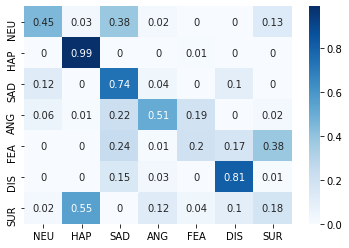

In [48]:
# EMOTION_CLASSES = ["neutral", "happiness", "sadness", "anger", "fear", "disgust", "surprise"]
EMOTION_CLASSES = ["NEU", "HAP", "SAD", "ANG", "FEA", "DIS", "SUR"]

conf_matrix_cnn_lip = numpy.round(best_cnn_lip["conf_matrix"], 2)
# print(type(conf_matrix_cnn_lip))
seaborn.heatmap(conf_matrix_cnn_lip, annot=True, xticklabels=EMOTION_CLASSES, yticklabels=EMOTION_CLASSES, cmap="Blues")

plt.savefig("resources/conf_mat_CNN_LIP.pdf")

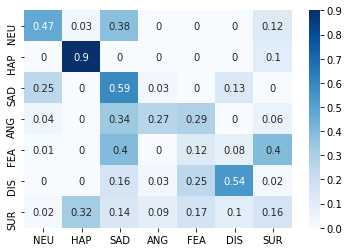

In [47]:
conf_matrix_cnn = numpy.round(cnn_no_lip["conf_matrix"], 2)
seaborn.heatmap(conf_matrix_cnn, annot=True, xticklabels=EMOTION_CLASSES, yticklabels=EMOTION_CLASSES, cmap="Blues")

plt.savefig("resources/conf_mat_CNN.pdf")

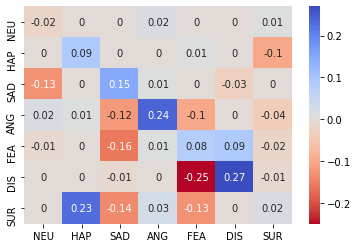

In [46]:
diff_matrix_cnn = numpy.round(conf_matrix_cnn_lip - conf_matrix_cnn, 2)
seaborn.heatmap(diff_matrix_cnn, annot=True, xticklabels=EMOTION_CLASSES, yticklabels=EMOTION_CLASSES, cmap="coolwarm_r")

plt.savefig("resources/conf_mat_CNN_diff.pdf")

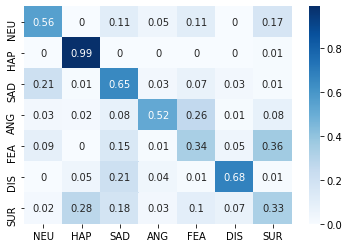

In [45]:
conf_matrix_rnn_lip = numpy.round(best_rnn_lip["conf_matrix"], 2)
seaborn.heatmap(conf_matrix_rnn_lip, annot=True, xticklabels=EMOTION_CLASSES, yticklabels=EMOTION_CLASSES, cmap="Blues")

plt.savefig("resources/conf_mat_RNN_LIP.pdf")

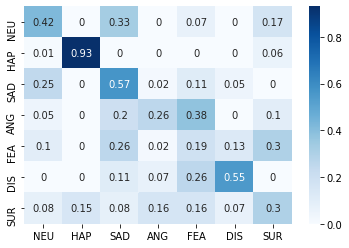

In [44]:
conf_matrix_rnn = numpy.round(rnn_no_lip["conf_matrix"], 2)
seaborn.heatmap(conf_matrix_rnn, annot=True, xticklabels=EMOTION_CLASSES, yticklabels=EMOTION_CLASSES, cmap="Blues")

plt.savefig("resources/conf_mat_RNN.pdf")

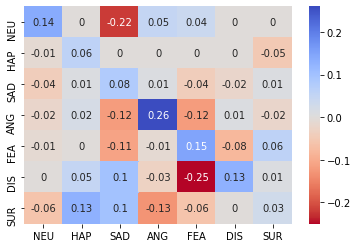

In [43]:
diff_matrix_rnn = numpy.round(conf_matrix_rnn_lip - conf_matrix_rnn, 2)
seaborn.heatmap(diff_matrix_rnn, annot=True, xticklabels=EMOTION_CLASSES, yticklabels=EMOTION_CLASSES, cmap="coolwarm_r")

plt.savefig("resources/conf_mat_RNN_diff.pdf")

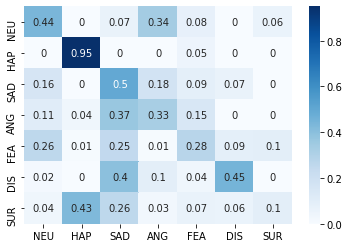

In [49]:
conf_matrix_frame = numpy.round(best_frame_model["conf_matrix"], 2)
seaborn.heatmap(conf_matrix_frame, annot=True, xticklabels=EMOTION_CLASSES, yticklabels=EMOTION_CLASSES, cmap="Blues")

plt.savefig("resources/conf_mat_FRAME.pdf")